In [1]:
import pingouin as pg
import matplotlib.pyplot as plt
import os
import h5py
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats

In [2]:
# Age
age = [22, 23, 23, 22, 22, 23, 23, 23, 21, 22, 23, 21, 18, 23, 20, 24, 21, 37, 40, 43]
print('mean =', np.average(age))
print('std =', np.std(age))

mean = 24.7
std = 6.626462102811726


In [3]:
# define style for figures
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")


In [4]:
# Get the current directory where the script is running
current_directory = os.getcwd()

# Get a list of all the participant folders (assuming they are all in the same directory)
participants_folders = sorted([f for f in os.listdir(current_directory) if os.path.isdir(f)])

# Initialize an empty list to store data
data = []

SN = 0  # Subject Number counter

# Loop through each participant folder
for folder in participants_folders:
    file_path = os.path.join(current_directory, folder, "all_trials.csv")  # Path to all_trials.csv
    
    if os.path.isfile(file_path):  # Check if the file exists
        data_temp = pd.read_csv(file_path)  # Read the CSV file

        # Insert the Subject Number (SN) as the first column
        data_temp.insert(0, "SN", SN)

        # Append to the list of data
        data.append(data_temp)
    SN += 1  # Increment Subject Number

# Merge all data into a single DataFrame
merged_df = pd.concat(data, ignore_index=True)

# Print the merged DataFrame (optional)
print(merged_df)

# Save to a new CSV file
merged_df.to_csv("merged_all_trials.csv", index=False)

      SN  assistance  block  trial  emg     score  score_feedback  rate
0      1        0.00      1      0    1  0.405413        0.405413     3
1      1        0.50      1      1    1  0.219117        0.609558     1
2      1        0.10      1      2    1  0.310939        0.379845     3
3      1        0.25      1      3    1 -0.234162        0.074379     3
4      1        0.25      1      4    1  0.098003        0.323502     6
...   ..         ...    ...    ...  ...       ...             ...   ...
2395  20        0.10      6     15    1  0.240152        0.316137     6
2396  20        0.00      6     16    1  0.445145        0.445145     7
2397  20        0.10      6     17    1  0.436270        0.492643     7
2398  20        0.25      6     18    1  0.124769        0.343577     7
2399  20        0.50      6     19    1  0.073693        0.536846     7

[2400 rows x 8 columns]


In [5]:
# Drop column 'trial and emg'
merged_df = merged_df.drop('trial', axis=1)
merged_df = merged_df.drop('emg', axis=1)

# Renaming columns
merged_df.rename(columns={'rate': 'SoA'}, inplace=True)
print(merged_df)


      SN  assistance  block     score  score_feedback  SoA
0      1        0.00      1  0.405413        0.405413    3
1      1        0.50      1  0.219117        0.609558    1
2      1        0.10      1  0.310939        0.379845    3
3      1        0.25      1 -0.234162        0.074379    3
4      1        0.25      1  0.098003        0.323502    6
...   ..         ...    ...       ...             ...  ...
2395  20        0.10      6  0.240152        0.316137    6
2396  20        0.00      6  0.445145        0.445145    7
2397  20        0.10      6  0.436270        0.492643    7
2398  20        0.25      6  0.124769        0.343577    7
2399  20        0.50      6  0.073693        0.536846    7

[2400 rows x 6 columns]


### SoA vs SN 

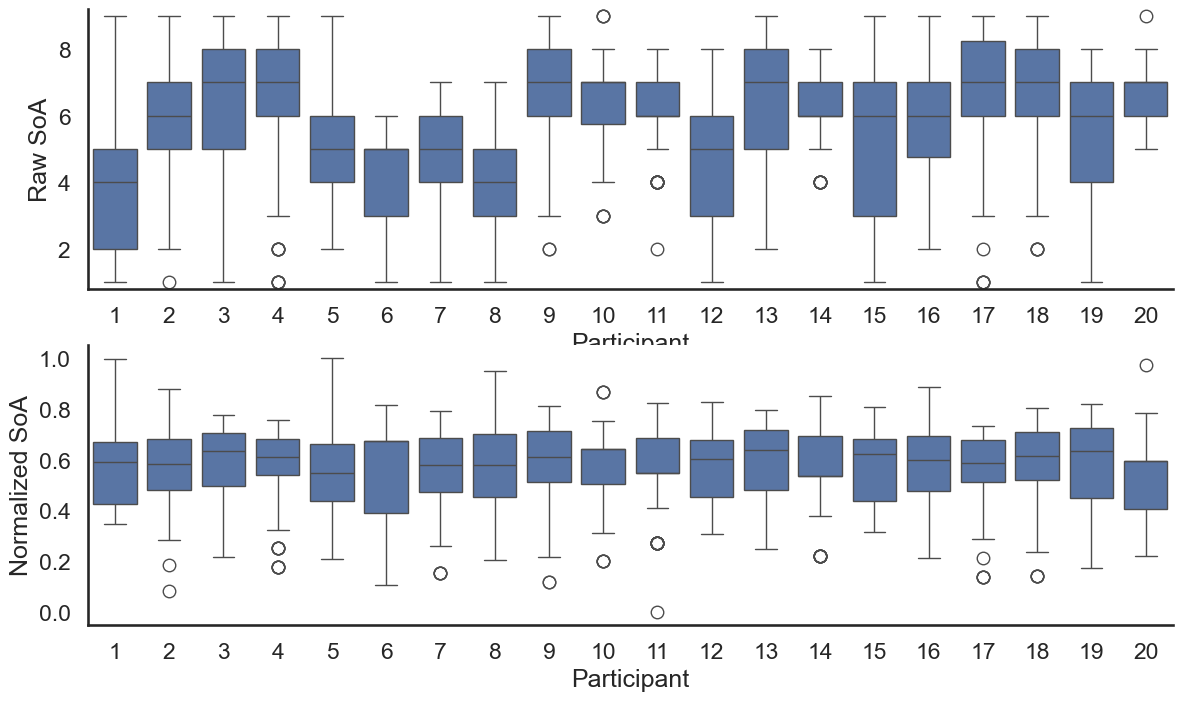

In [6]:
import matplotlib.pyplot as plt

# Apply Min-Max scaling globally to the z-score normalized values
merged_df["SoA_normalized"] = merged_df.groupby("SN")["SoA"].transform(lambda x: (x - x.mean()) / x.std())
min_value = merged_df["SoA_normalized"].min()
max_value = merged_df["SoA_normalized"].max()
merged_df["SoA_normalized"] = (merged_df["SoA_normalized"] - min_value) / (max_value - min_value)


# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot SoA vs SN on the first subplot
sns.boxplot(data=merged_df, x='SN', y='SoA', ax=axes[0])
axes[0].set_xlabel('Participant')
axes[0].set_ylabel('Raw SoA')
axes[0].set(ylim=(0.8, 9.2))
sns.despine(ax=axes[0])

# Plot SoA vs SN normalized on the second subplot
sns.boxplot(data=merged_df, x='SN', y='SoA_normalized', ax=axes[1])
axes[1].set_xlabel('Participant')
axes[1].set_ylabel('Normalized SoA')
sns.despine(ax=axes[1])

# Show the figure
plt.show()


In [7]:
pg.anova(data=merged_df, dv='SoA', between='SN', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,SN,2069.398333,19,108.915702,38.361572,4.628090e-123,0.234448
1,Within,6757.266667,2380,2.839188,NaN,NaN,NaN


#### Results
Statistically Significant: The SN factor has a statistically significant effect on SoA (p-value < 0.05).

Large Effect Size: The effect size is large (23%), indicating that SN explains a substantial portion of the variance in SoA.

### Score feedback vs Score when Assistance = 0.0

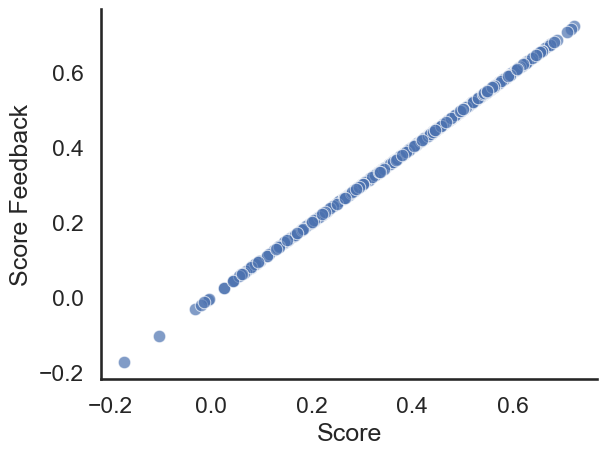

In [8]:
# Filter the dataframe to include only rows where assistance = 0.0
df_filtered = merged_df[merged_df['assistance'] == 0.0]

# Create scatter plot
ax = sns.scatterplot(x=df_filtered["score"], y=df_filtered["score_feedback"], alpha=0.7)
sns.despine()
ax.set_ylabel('Score Feedback')
ax.set_xlabel('Score')
plt.show()

## Averaged to have 1 input for each assistance level in each block, per participant

In [9]:
# Average them to have 1 input for each assistance level in each block
df_grouped = merged_df.groupby(['SN', 'block', 'assistance']).mean().reset_index()

# Display the new dataframe
print(df_grouped)

     SN  block  assistance     score  score_feedback  SoA  SoA_normalized
0     1      1        0.00  0.439978        0.439978  5.0        0.670334
1     1      1        0.10  0.316674        0.385006  4.4        0.621627
2     1      1        0.25  0.141992        0.356494  4.6        0.637862
3     1      1        0.50 -0.012935        0.493532  2.0        0.426799
4     1      2        0.00  0.543683        0.543683  5.8        0.735276
..   ..    ...         ...       ...             ...  ...             ...
475  20      5        0.50  0.384159        0.692080  6.0        0.407369
476  20      6        0.00  0.386389        0.386389  6.8        0.557532
477  20      6        0.10  0.387112        0.448401  6.6        0.519991
478  20      6        0.25  0.365720        0.524290  6.8        0.557532
479  20      6        0.50  0.280571        0.640286  5.6        0.332288

[480 rows x 7 columns]


## Plots grouped

aprenantatge continuu: regresiio de SoA per numero de trial controlant per assis

C:\Users\merin\AppData\Local\Temp\ipykernel_11520\548130207.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_grouped, x='block', y='SoA', palette="Blues")


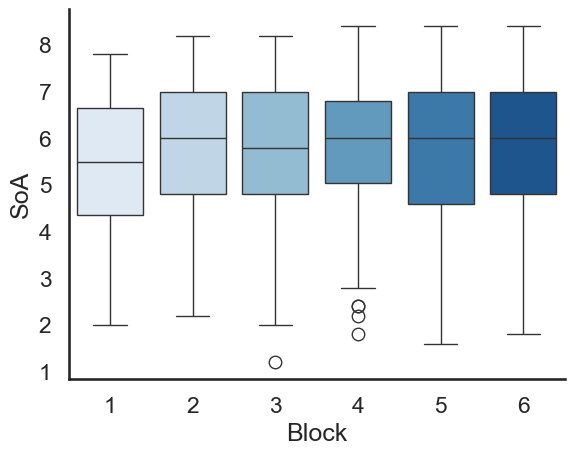

In [10]:
# plot SoA vs Block to see a trend
plt = sns.boxplot(data=df_grouped, x='block', y='SoA', palette="Blues")
plt.set_xlabel('Block')
plt.set_ylabel('SoA')

sns.despine()

C:\Users\merin\AppData\Local\Temp\ipykernel_11520\1254094674.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_grouped, x='assistance', y='SoA', palette="Blues")
C:\Users\merin\AppData\Local\Temp\ipykernel_11520\1254094674.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


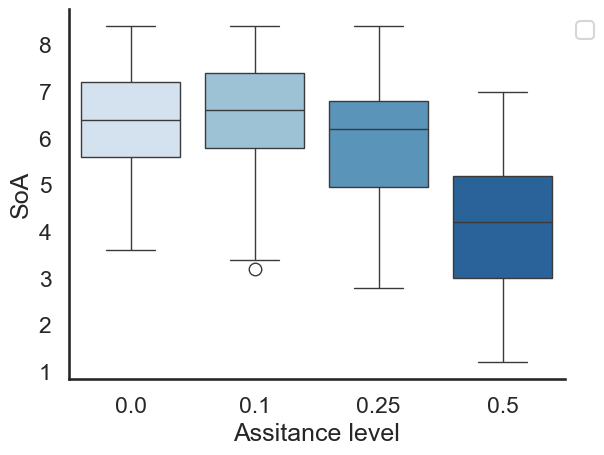

In [11]:
# plot SoA vs Assistance
plt = sns.boxplot(data=df_grouped, x='assistance', y='SoA', palette="Blues")
plt.set_xlabel('Assitance level')
plt.set_ylabel('SoA')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

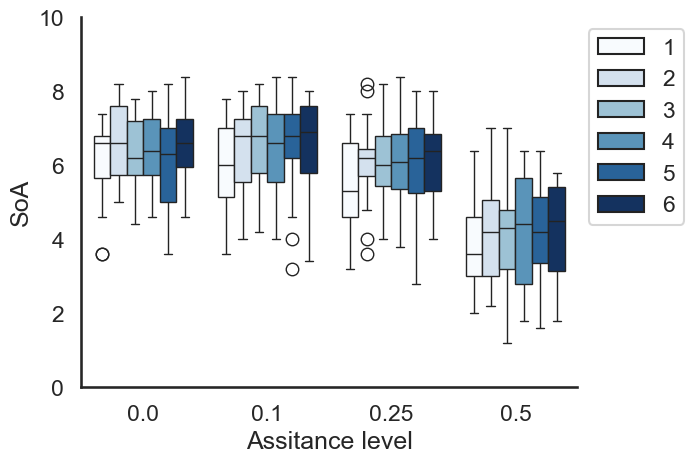

In [20]:
# plot SoA vs Assistance
plt = sns.boxplot(data=df_grouped, x='assistance', y='SoA', hue='block', palette="Blues")
plt.set_xlabel('Assitance level')
plt.set_ylabel('SoA')
plt.set_ylim(0, 10)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

sns.despine()

## 2-way ANOVA

In [13]:
# two-way anova
model = ols('SoA ~ C(block) + C(assistance) + C(block):C(assistance)', data=df_grouped).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(block),14.842,5.0,1.883995,9.572998e-02
C(assistance),430.235,3.0,91.021061,3.580845e-46
C(block):C(assistance),5.148,15.0,0.217823,9.992752e-01
Residual,718.468,456.0,NaN,NaN


### 2-way anova results
statistical difference for Assistance and block, no interaction effect.
We can look at each separately and do a post-hoc test

## Group by assistance

In [14]:
# Group by assistance level. One assistance level for each subject
df_assis = df_grouped.groupby(['SN', 'assistance']).mean().reset_index()

# Erase block column
df_assis = df_assis.drop('block', axis=1)

# Display the new dataframe
print(df_assis)

    SN  assistance     score  score_feedback       SoA  SoA_normalized
0    1        0.00  0.317041        0.317041  4.833333        0.656804
1    1        0.10  0.322473        0.390226  4.066667        0.594567
2    1        0.25  0.243161        0.432371  4.233333        0.608097
3    1        0.50  0.025323        0.512661  2.233333        0.445741
4    2        0.00  0.373474        0.373474  5.766667        0.558128
..  ..         ...       ...             ...       ...             ...
75  19        0.50  0.204255        0.602127  3.800000        0.431785
76  20        0.00  0.452563        0.452563  7.200000        0.632613
77  20        0.10  0.437626        0.493864  7.166667        0.626356
78  20        0.25  0.397367        0.548026  6.866667        0.570045
79  20        0.50  0.328690        0.664345  6.366667        0.476194

[80 rows x 6 columns]


C:\Users\merin\AppData\Local\Temp\ipykernel_11520\868861367.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_assis, x='assistance', y='SoA', palette="Blues")


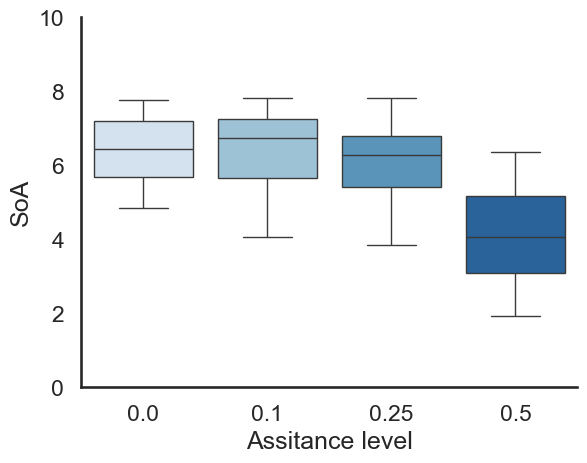

In [65]:
# plot SoA vs Assistance
plt = sns.boxplot(data=df_assis, x='assistance', y='SoA', palette="Blues")
plt.set_xlabel('Assitance level')
plt.set_ylabel('SoA')
plt.set_ylim(0, 10)

sns.despine()

In [16]:
# statistics on SoA between assistance
pg.anova(data=df_assis, dv='SoA', between='assistance', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,assistance,71.705833,3,23.901944,19.016863,2.680612e-09,0.428789
1,Within,95.523000,76,1.256882,NaN,NaN,NaN


### Because is statiscal significant I can do the pairwise

Post-hoc Wilcoxon

In [72]:
import scikit_posthocs as sp

# Function to convert p-values to asterisks
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# Perform post-hoc pairwise Wilcoxon test
posthoc_results = sp.posthoc_wilcoxon(df_assis, val_col='SoA', group_col='assistance', p_adjust='holm')

# Convert the results to a long-format DataFrame for better readability
posthoc_data = posthoc_results.stack().reset_index()
posthoc_data.columns = ['group1', 'group2', 'p-value']

# Filter out duplicate comparisons
posthoc_data = posthoc_data[posthoc_data['group1'] < posthoc_data['group2']]

# Add significance levels
posthoc_data['significance'] = posthoc_data['p-value'].apply(convert_pvalue_to_asterisks)

# Print the results
print(posthoc_data)

    group1  group2   p-value significance
1     0.00    0.10  0.967890           ns
2     0.00    0.25  0.059151           ns
3     0.00    0.50  0.000019          ***
6     0.10    0.25  0.019434            *
7     0.10    0.50  0.000019          ***
11    0.25    0.50  0.000011          ***


### Results pairwise
There are significant differences between all pairs of groups, except for the comparison between 0.00 and 0.10.

The largest differences are observed between the groups with 0.10 and 0.50, indicating that the higher levels of assistance have a more substantial impact on SoA_normalized.

### Plot with significance lines

In [73]:
# Function to convert p-values to asterisks
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# Calculate p-values for pairwise comparisons
assistance_levels = df_assis["assistance"].unique()
pvalues = []
comparisons = []

for i, level1 in enumerate(assistance_levels):
    for level2 in assistance_levels[i+1:]:
        stat, pvalue = stats.ttest_ind(
            df_assis[df_assis["assistance"] == level1]["SoA"],
            df_assis[df_assis["assistance"] == level2]["SoA"]
        )
        pvalues.append(pvalue)
        comparisons.append((level1, level2))


C:\Users\merin\AppData\Local\Temp\ipykernel_11520\1091567731.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_assis, x='assistance', y='SoA', palette="Blues")


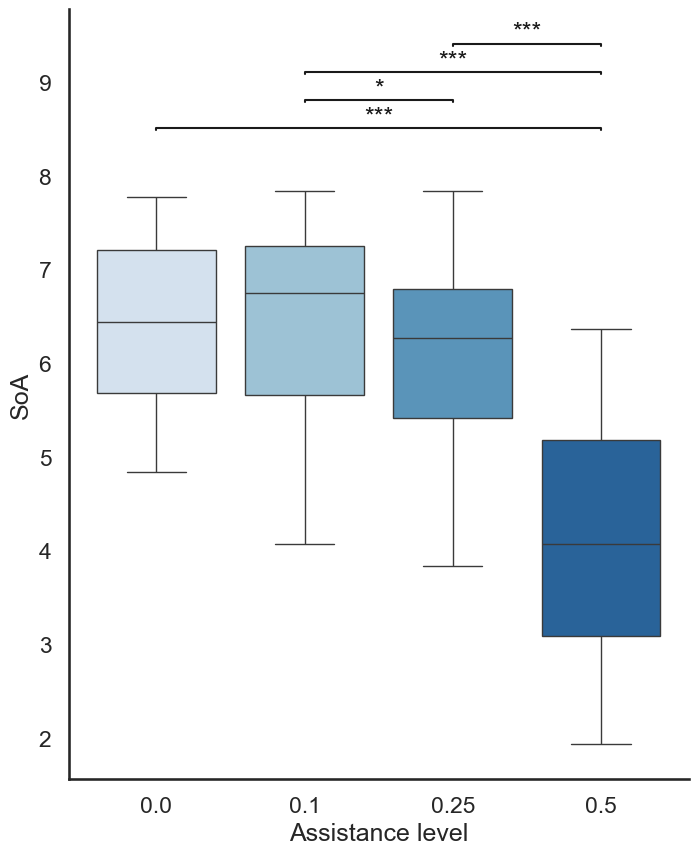

In [75]:
import matplotlib.pyplot as plt

# Plot SoA vs Assistance
plt.figure(figsize=(8, 10))
ax = sns.boxplot(data=df_assis, x='assistance', y='SoA', palette="Blues")
ax.set_xlabel('Assistance level')
ax.set_ylabel('SoA')
# ax.set_ylim(0, 10)
sns.despine()

# Add significance lines with separation
def add_significance_lines(ax, comparisons, pvalues, y_offset=0.05, separation=0.3):
    for i, ((level1, level2), pvalue) in enumerate(zip(comparisons, pvalues)):
        if pvalue < 0.05:
            x1, x2 = assistance_levels.tolist().index(level1), assistance_levels.tolist().index(level2)
            y, h, col = df_assis["SoA"].max() + y_offset + i * separation, 0.02, 'k'
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(pvalue), ha='center', va='bottom', color=col)

# Extract comparisons and p-values from posthoc_data
comparisons = list(zip(posthoc_data['group1'], posthoc_data['group2']))
pvalues = posthoc_data['p-value'].tolist()

add_significance_lines(ax, comparisons, pvalues)

plt.show()

In [ ]:
# # post-hoc pairwise tukey test assistance
# test = pairwise_tukeyhsd(endog=df_assis['SoA_normalized'], groups=df_assis['assistance'], alpha=0.05)

# tukey_data = pd.DataFrame(data=test._results_table.data[1:], columns=test._results_table.data[0])
# tukey_data

## Score feedback and assistance

C:\Users\merin\AppData\Local\Temp\ipykernel_11520\385196333.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_assis, x='assistance', y='score_feedback', palette="Blues")


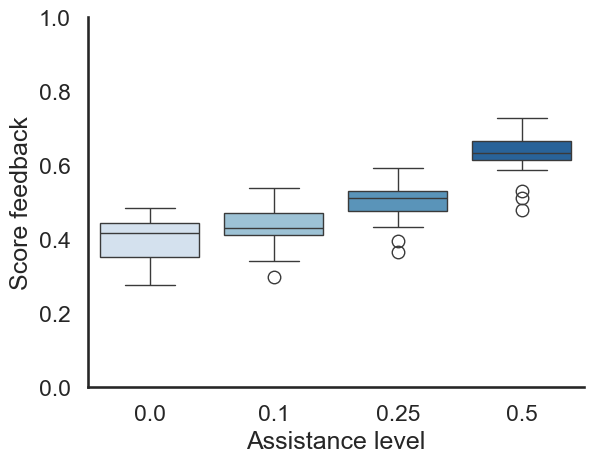

In [64]:
# Score feedback vs Assistance
plt = sns.boxplot(data=df_assis, x='assistance', y='score_feedback', palette="Blues")
plt.set_xlabel('Assistance level')
plt.set_ylabel('Score feedback')
plt.set(ylim=(0,1))

sns.despine()

In [ ]:
# statistics on SoA between assistance
pg.anova(data=df_assis, dv='score_feedback', between='assistance', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,assistance,0.637531,3,0.212510,58.574545,1.015645e-19,0.698082
1,Within,0.275730,76,0.003628,NaN,NaN,NaN


Post-hoc Wilcoxon

In [ ]:
# Perform post-hoc pairwise Wilcoxon test
posthoc_results = sp.posthoc_wilcoxon(df_assis, val_col='score_feedback', group_col='assistance', p_adjust='holm')

# Convert the results to a long-format DataFrame for better readability
posthoc_data = posthoc_results.stack().reset_index()
posthoc_data.columns = ['group1', 'group2', 'p-value']

# Filter out duplicate comparisons
posthoc_data = posthoc_data[posthoc_data['group1'] < posthoc_data['group2']]

# Add significance levels
posthoc_data['significance'] = posthoc_data['p-value'].apply(convert_pvalue_to_asterisks)

# Print the results
print(posthoc_data)

    group1  group2   p-value significance
1     0.00    0.10  0.000105          ***
2     0.00    0.25  0.000011          ***
3     0.00    0.50  0.000011          ***
6     0.10    0.25  0.000011          ***
7     0.10    0.50  0.000011          ***
11    0.25    0.50  0.000011          ***


Plot with significance lines

C:\Users\merin\AppData\Local\Temp\ipykernel_17172\3872582364.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_assis, x='assistance', y='score_feedback', palette="Blues")


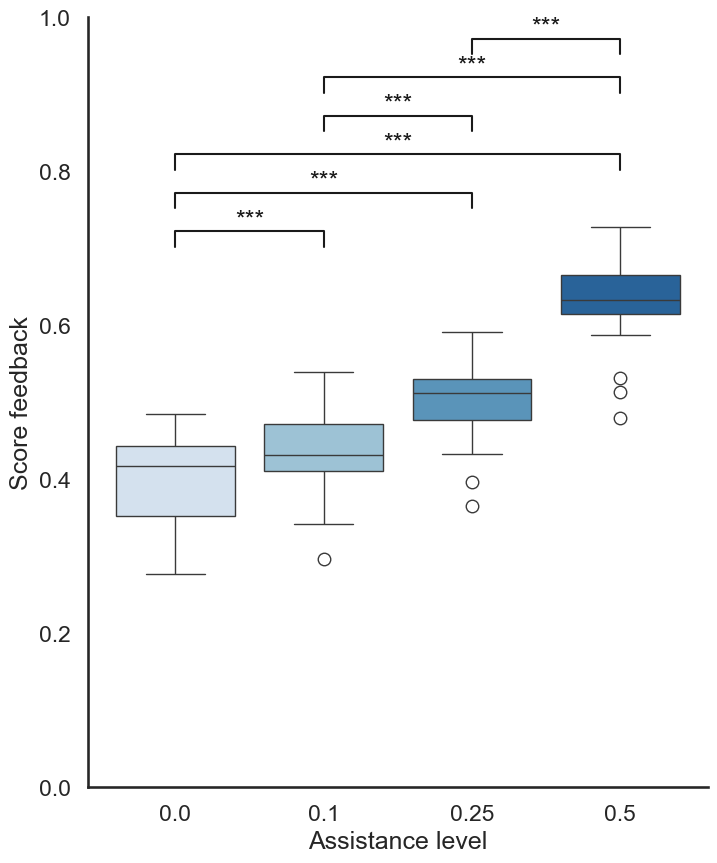

In [ ]:
import matplotlib.pyplot as plt

# Calculate p-values for pairwise comparisons
assistance_levels = df_assis["assistance"].unique()
pvalues = []
comparisons = []

for i, level1 in enumerate(assistance_levels):
    for level2 in assistance_levels[i+1:]:
        stat, pvalue = stats.ttest_ind(
            df_assis[df_assis["assistance"] == level1]["score_feedback"],
            df_assis[df_assis["assistance"] == level2]["score_feedback"]
        )
        pvalues.append(pvalue)
        comparisons.append((level1, level2))

# Plot SoA vs Assistance
plt.figure(figsize=(8, 10))
ax = sns.boxplot(data=df_assis, x='assistance', y='score_feedback', palette="Blues")
ax.set_xlabel('Assistance level')
ax.set_ylabel('Score feedback')
ax.set_ylim(0, 1)
sns.despine()

# Add significance lines with separation
def add_significance_lines(ax, comparisons, pvalues, y_offset=0.005, separation=0.05):
    for i, ((level1, level2), pvalue) in enumerate(zip(comparisons, pvalues)):
        if pvalue < 0.05:
            x1, x2 = assistance_levels.tolist().index(level1), assistance_levels.tolist().index(level2)
            y, h, col = df_assis["score_feedback"].max() + y_offset + i * separation, 0.02, 'k'
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
            ax.text((x1+x2)*.5, y+h, convert_pvalue_to_asterisks(pvalue), ha='center', va='bottom', color=col)

# Extract comparisons and p-values from posthoc_data
comparisons = list(zip(posthoc_data['group1'], posthoc_data['group2']))
pvalues = posthoc_data['p-value'].tolist()

add_significance_lines(ax, comparisons, pvalues)

plt.show()

### Mixed-Effects Model to handle continuous predictors and repeated measures, making it flexible for the data

Handling Random Effects: Mixed-effects models can account for random effects, such as variability between participants (SN), which is crucial when you have repeated measures or hierarchical data structures. This allows for more accurate modeling of the data.

Flexibility with Data: Mixed-effects models are more flexible in handling data that may not meet the assumptions of ANOVA, such as non-normality or unequal variances. They can accommodate complex data structures and interactions more effectively.

Convergence Issues: The convergence issue in your ANOVA model suggests that the data might not fit well within the assumptions required for ANOVA. Mixed-effects models can often handle such data better, providing more reliable results.

Detailed Insights: Mixed-effects models provide detailed insights into both fixed effects (e.g., assistance, score_feedback) and random effects (e.g., variability between participants), which can be valuable for understanding the impact of different factors on your dependent variable.

Given these advantages, the mixed-effects model might be more appropriate for your data, especially if you have repeated measures or hierarchical data structures. If you still encounter issues with ANOVA, you might consider alternative non-parametric tests like the Friedman test or other robust statistical methods.

In [ ]:
from statsmodels.formula.api import mixedlm

# Fit the mixed-effects model
model = mixedlm('SoA ~ assistance * score_feedback', data=df_assis, groups=df_assis['SN'])
result = model.fit()

# Print the summary of the model
print(result.summary())

c:\Users\merin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\merin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\merin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\merin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


               Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   SoA_normalized
No. Observations:     80        Method:               REML          
No. Groups:           20        Scale:                0.0016        
Min. group size:      4         Log-Likelihood:       137.7346      
Max. group size:      4         Converged:            No            
Mean group size:      4.0                                           
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.497    0.042 11.854 0.000  0.415  0.579
assistance                 0.471    0.140  3.364 0.001  0.197  0.746
score_feedback             0.374    0.100  3.759 0.000  0.179  0.570
assistance:score_feedback -1.689    0.258 -6.539 0.000 -2.196 -1.183
Group Var                  0.000                  

c:\Users\merin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\merin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\merin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.200060
  warnings.warn(msg, ConvergenceWarning)
c:\Users\merin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\merin\AppD

### Results
Assistance has a significant positive effect on SoA_normalized (0.471). z-score= 3.364 and p = 0.001 significant effect

Score_feedback has a significant effect on SoA_normalized (0.374). z-score= 3.759 and p = 0.000 significant effect

The interaction between assistance and score_feedback is significant and negative (-1.689), suggesting that the combined effect of assistance and score_feedback reduces SoA_normalized.

## Group by block

In [66]:
# Group by block. One ablock for each subject
df_block = df_grouped.groupby(['SN', 'block']).mean().reset_index()

# Erase block column
df_block = df_block.drop('assistance', axis=1)

# Display the new dataframe
# print(df_block)

C:\Users\merin\AppData\Local\Temp\ipykernel_11520\10390302.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plt = sns.boxplot(data=df_block, x='block', y='SoA', palette="Blues")


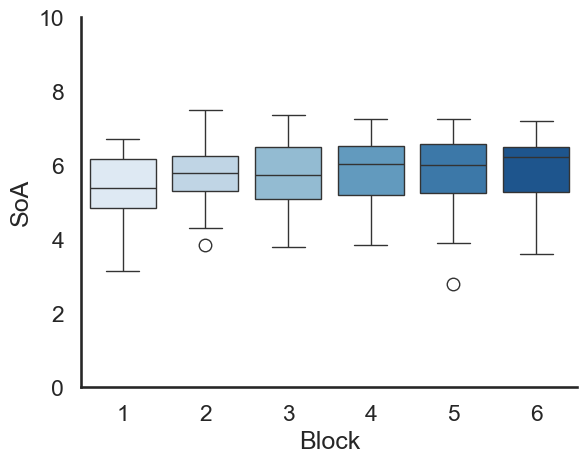

In [70]:
# plot SoA vs Block to see a trend
plt = sns.boxplot(data=df_block, x='block', y='SoA', palette="Blues")
plt.set_xlabel('Block')
plt.set_ylabel('SoA')
plt.set_ylim(0, 10)

sns.despine()

No significance lines as there's no significance in the pairwise

In [68]:
# statistics on SoA between blocks
pg.anova(data=df_block, dv='SoA', between='block', detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,block,3.71050,5,0.742100,0.706569,0.619663,0.030058
1,Within,119.73275,114,1.050287,NaN,NaN,NaN


As it is statiscal significant I can do the pairwise

# Change to wilcoxon
Non-parametric test (equivalent to t-test)

In [69]:
# Perform post-hoc pairwise Wilcoxon test
posthoc_results = sp.posthoc_wilcoxon(df_block, val_col='SoA', group_col='block', p_adjust='holm')

# Convert the results to a long-format DataFrame for better readability
posthoc_data = posthoc_results.stack().reset_index()
posthoc_data.columns = ['group1', 'group2', 'p-value']

# Filter out duplicate comparisons
posthoc_data = posthoc_data[posthoc_data['group1'] < posthoc_data['group2']]

# Add significance levels
posthoc_data['significance'] = posthoc_data['p-value'].apply(convert_pvalue_to_asterisks)

# Print the results
print(posthoc_data)

    group1  group2   p-value significance
1        1       2  0.074147           ns
2        1       3  0.059884           ns
3        1       4  0.059884           ns
4        1       5  0.560136           ns
5        1       6  0.059884           ns
8        2       3  1.000000           ns
9        2       4  1.000000           ns
10       2       5  1.000000           ns
11       2       6  1.000000           ns
15       3       4  1.000000           ns
16       3       5  1.000000           ns
17       3       6  1.000000           ns
22       4       5  1.000000           ns
23       4       6  1.000000           ns
29       5       6  1.000000           ns


### Line trend inserted and p-value of the slope of the line for the following two graphs

Slope (correlation strength): 0.0129
Intercept: 0.2664
R-squared (correlation coefficient squared): 0.0348


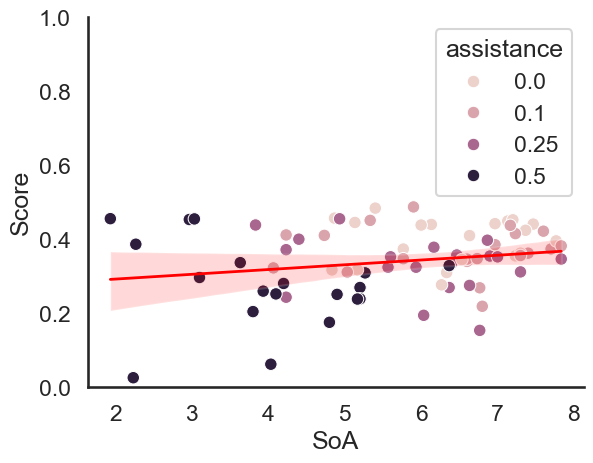

In [76]:
from scipy.stats import linregress

# SoA vs score
plt = sns.scatterplot(data=df_assis, x='SoA', y='score', hue='assistance')

# Add best fit line (without hue)
sns.regplot(data=df_assis, x='SoA', y='score', scatter=False, color='red', line_kws={'linewidth': 2})

plt.set_xlabel('SoA')
plt.set_ylabel('Score')
plt.set(ylim=(0,1))

sns.despine()

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(df_assis['SoA'], df_assis['score'])

print(f"Slope (correlation strength): {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared (correlation coefficient squared): {r_value**2:.4f}")

Slope (correlation strength): -0.0440
Intercept: 0.7409
R-squared (correlation coefficient squared): 0.3543


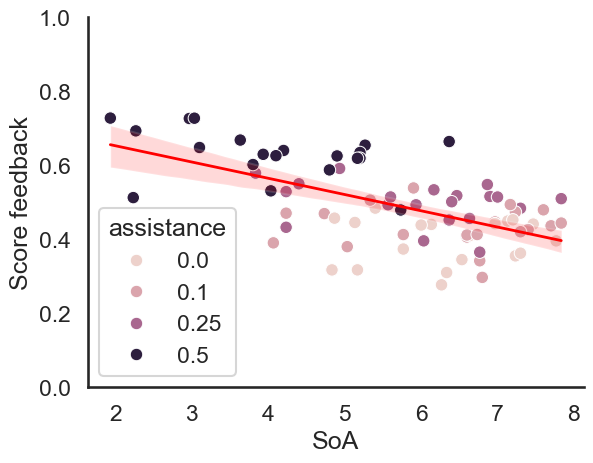

In [81]:
# SoA vs score
plt = sns.scatterplot(data=df_assis, x='SoA', y='score_feedback', hue='assistance')

# Add best fit line (without hue)
sns.regplot(data=df_assis, x='SoA', y='score_feedback', scatter=False, color='red', line_kws={'linewidth': 2})

plt.set_xlabel('SoA')
plt.set_ylabel('Score feedback')
plt.set(ylim=(0,1))

sns.despine()

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(df_assis['SoA'], df_assis['score_feedback'])

print(f"Slope (correlation strength): {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R-squared (correlation coefficient squared): {r_value**2:.4f}")

## SoA distribution

In [78]:
merged_df

,SN,assistance,block,score,score_feedback,SoA,SoA_normalized
0,1,0.00,1,0.405413,0.405413,3,0.507977
1,1,0.50,1,0.219117,0.609558,1,0.345621
2,1,0.10,1,0.310939,0.379845,3,0.507977
3,1,0.25,1,-0.234162,0.074379,3,0.507977
4,1,0.25,1,0.098003,0.323502,6,0.751512
...,...,...,...,...,...,...,...
2395,20,0.10,6,0.240152,0.316137,6,0.407369
2396,20,0.00,6,0.445145,0.445145,7,0.595072
2397,20,0.10,6,0.436270,0.492643,7,0.595072
2398,20,0.25,6,0.124769,0.343577,7,0.595072


C:\Users\merin\AppData\Local\Temp\ipykernel_11520\343895712.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist_plot = sns.histplot(data=merged_df, x='SoA', bins=9, kde=False, palette="mako")
C:\Users\merin\AppData\Local\Temp\ipykernel_11520\343895712.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  hist_plot.set_xticklabels([f'{x:.1f}' for x in hist_plot.get_xticks()])


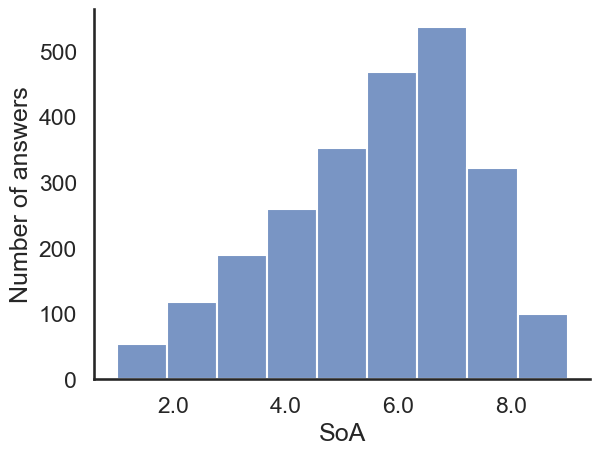

In [79]:
import matplotlib.pyplot as plt

# SoA vs Number of answers
# hist_plot = sns.histplot(data=df_filtered, x='SoA_normalized', bins=9, kde=False, palette="mako")
hist_plot = sns.histplot(data=merged_df, x='SoA', bins=9, kde=False, palette="mako")

# hist_plot = sns.histplot(data=df_filtered, x='SoA_normalized', bins=11, kde=False, palette="mako")

# Set labels
hist_plot.set_xlabel('SoA')
hist_plot.set_ylabel('Number of answers')
hist_plot.set_xticklabels([f'{x:.1f}' for x in hist_plot.get_xticks()])

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

In [80]:
# SoA vs Number of answers
test2 = pd.DataFrame({'count': merged_df.groupby(["SoA"]).size()}).reset_index()

test2

,SoA,count
0,1,53
1,2,118
2,3,190
3,4,260
4,5,353
5,6,468
6,7,537
7,8,322
8,9,99
